In [1]:
import altair as alt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns
from bs4 import BeautifulSoup
from sklearn.utils.random import sample_without_replacement

alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

# small parameter overview



**accousticness**: A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.


**energy**: Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.


**instrumentalness**: Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.


**key**: The key the track is in. Integers map to pitches using standard Pitch Class notation.


**liveness**: Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.


**loudness**: The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.


**mode**: Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.


**speechiness**: Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.

[source](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-analysis/)

**task**: predict popularity of a song (regression) based solely on other features/characterics of the music track

- impact of the artist's name on the popularity seems quiet obvious but also quiet a complex task (high cardinality data involving of processing to do), so I ll drop this parameter
    - also see quiet fun to primarily focus parameters charcterizing the music track itself
- **production year** and **release date** are in most case very near by another (at least at the year resolution), so I ll drop the release date

In [2]:
df = pd.read_csv('./archive/data.csv')

In [3]:
df.describe()

,valence,year,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo
count,170653.000000,170653.000000,170653.000000,170653.000000,1.706530e+05,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000,170653.000000
mean,0.528587,1976.787241,0.502115,0.537396,2.309483e+05,0.482389,0.084575,0.167010,5.199844,0.205839,-11.467990,0.706902,31.431794,0.098393,116.861590
std,0.263171,25.917853,0.376032,0.176138,1.261184e+05,0.267646,0.278249,0.313475,3.515094,0.174805,5.697943,0.455184,21.826615,0.162740,30.708533
min,0.000000,1921.000000,0.000000,0.000000,5.108000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,-60.000000,0.000000,0.000000,0.000000,0.000000
25%,0.317000,1956.000000,0.102000,0.415000,1.698270e+05,0.255000,0.000000,0.000000,2.000000,0.098800,-14.615000,0.000000,11.000000,0.034900,93.421000
50%,0.540000,1977.000000,0.516000,0.548000,2.074670e+05,0.471000,0.000000,0.000216,5.000000,0.136000,-10.580000,1.000000,33.000000,0.045000,114.729000
75%,0.747000,1999.000000,0.893000,0.668000,2.624000e+05,0.703000,0.000000,0.102000,8.000000,0.261000,-7.183000,1.000000,48.000000,0.075600,135.537000
max,1.000000,2020.000000,0.996000,0.988000,5.403500e+06,1.000000,1.000000,1.000000,11.000000,1.000000,3.855000,1.000000,100.000000,0.970000,243.507000


In [4]:
df.nunique() 

valence               1733
year                   100
acousticness          4689
artists              34088
danceability          1240
duration_ms          51755
energy                2332
explicit                 2
id                  170653
instrumentalness      5401
key                     12
liveness              1740
loudness             25410
mode                     2
name                133638
popularity             100
release_date         11244
speechiness           1626
tempo                84694
dtype: int64

# music track characteristics

<AxesSubplot:>

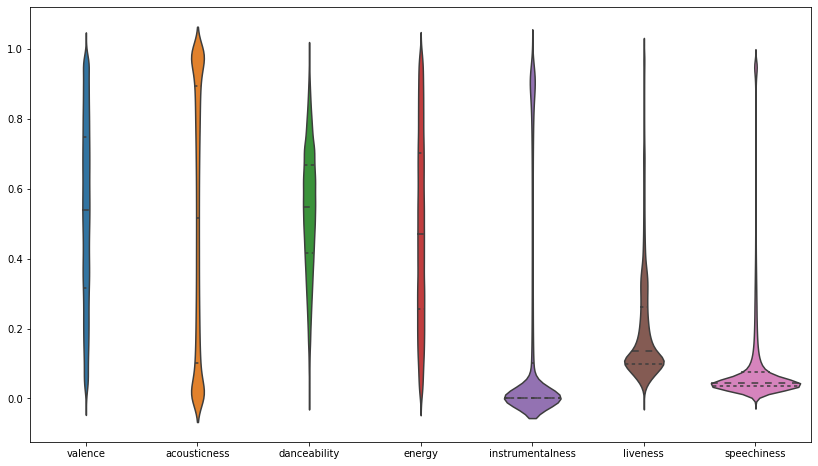

In [5]:
fig, ax = plt.subplots(1,1, figsize=(14,8))
sns.violinplot(
    data=df.select_dtypes([int,float])
            .drop(
                [
                    'year', 'duration_ms', 
                    'loudness', 'popularity', 
                    'tempo', 'key', 'mode', 'explicit'
                ],
                axis=1
            ),
    inner='quartile',
    ax=ax,
)

<AxesSubplot:>

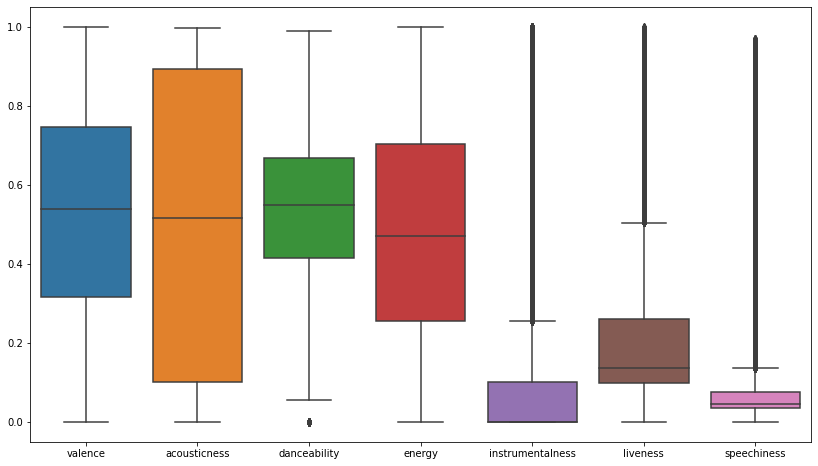

In [6]:
fig, ax = plt.subplots(1,1, figsize=(14,8))
sns.boxplot(
    data=df.select_dtypes([int,float])
            .drop(
                [
                    'year', 'duration_ms', 
                    'loudness', 'popularity', 
                    'tempo', 'key', 'mode', 'explicit'
                ],
                axis=1
            ),
    ax=ax,
)

the characteric "features" of track provided by spotify with (0,1)-range exhibit very strange and mostly highly non-normal distributions.

**instrumentation,speechness,liveness**
- both show highly skewed distribution (heavy right tailed narrow "gaussian")
- hint of superposition (small bumps in right corners)
- instrumentation and speechness have a very similar shape

**danceability**
- very flat symmetric and centered distribution (0.5)

**valence,energy**
- almost uniform distribution with 
    
**acousticness**
- feels like binary entity with two buldges occuring on both ends of the distribution
- otherwise very flat
- median and mean have no meaning

unfortunetly I do not have enough computer resource to perform a full bivariate investigation 
(even with random subsampling)

In [7]:
import matplotlib.pyplot as plt

In [8]:
base = alt.Chart(df.iloc[idx]).mark_bar()
row = alt.hconcat()    
for c in ('tempo', 'loudness', 'duration_ms', 'popularity', 'year'):    
    row |= base.encode(
            alt.X(c, bin=alt.Bin(maxbins=50)),
            alt.Y('count():Q'),
            tooltip=['count():Q'],
        ).properties(width=200, height=500)
row

NameError: name 'idx' is not defined

- **popularity** the target has a very strange anomaly,i.e.
very large count in there lowest value 0

- maybe this value encode a different type of information? needs to be investigated -
  could not find any information in the [spotify api doc](https://developer.spotify.com/documentation/web-api/reference/tracks/get-several-audio-features)
  
- **tempo** shows a symmetric distribution centered around 120 bpm with a gap in the appr. range (0,30). music within this range probably doesn't exist. Tempo 0 could be podcasts or audiobooks or music with complex rythms/unclear tempo?

- **loudness** left skewed distribution 

- **duration_ms** seems to be poisson distributed (and not a truncated normal distribution)
     - makes sense since poisson distribution express "the probabilty of event occuring in specified interval with a known constant mean rate and independent of other events" wikipedia
     
- **year** almost uniformly distributed with a drastic drop occuring around the 1940s

# anomaly investigation

In [ ]:
 data = (
     df.where(lambda r: r.popularity == 0)
      .dropna()
      .loc[:,['tempo', 'loudness', 'danceability', 'year']]
 )
    
sample_size = 5000
idx = sample_without_replacement(data.shape[0], sample_size)

g = sns.PairGrid(data.iloc[idx],diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)

In [ ]:
data = (
    df.where(lambda r: r.popularity != 0)
      .dropna()
      .loc[:,['tempo', 'loudness', 'danceability', 'year']]
)
sample_size = 5000
idx = sample_without_replacement(data.shape[0], sample_size)
g = sns.PairGrid(data.iloc[idx], diag_sharey=False)
g.map_upper(sns.scatterplot, s=15)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw=2)

In [ ]:
df.where(lambda r: r.tempo == 0).dropna()

In [ ]:
df.where(lambda r: r.loudness == -60).dropna()

In [ ]:
(
    alt.Chart(df)
    .transform_filter(alt.datum.popularity == 0)
    .mark_bar()
    .encode(x='year', y='count():Q')
    .properties(width=600, height=500, title='track count with zero popularity vs year')
)

In [ ]:
(
alt.Chart(df)
    .mark_bar()
    .encode(x='year', y='mean(popularity):Q')
    .properties(width=600, height=500)   
)

In [ ]:
from sklearn.utils.random import sample_without_replacement

X = df.select_dtypes([int,float]).values
cols = df.select_dtypes([int, float]).columns
N = X.shape[0]
#idx = sample_without_replacement(N, 0.5*N) 


In [ ]:
corrX = np.corrcoef(X.T)

In [ ]:
import plotly.express as px

px.imshow(
    pd.DataFrame(
        corrX, columns=list(cols)
    ),
    y=list(cols),
    color_continuous_scale='Viridis'
)

# covariance matrix insights gain

**Directly visible effects on popularity(target variable)**

- popularity of tracks strongly depends on the year the music track was produced
- positive corr indicates that a trend in increasing popularity with increasing year 
    - the more recent the track is the more popular it is / modern music is popular
- loudness and energy seems also to have positive effect on popularity
- whereas acousticness seems to have a negative impact on popularity
- unexpectedly both instrumentalness and danceability exhibit relatively low corr.
 
(however we should not forget that covariance solely captures the tendency in linear rel.)
   
**Correlation between predictors**

- there seems to be a strong correlation between loudness, energy and acousticness
- since energetic tracks "feel fast, **loud**, and noisy" this leads to an obvious
  connection between loudness and energy
- to my knowledge the majority of acoustic songs are not known to 'energetic and loud'
  (with exception of crazy classical music)
 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    df.select_dtypes([int, float]).drop('popularity', axis=1).values,
    df['popularity'].values,
    test_size=0.3
)

In [ ]:
clf = RandomForestClassifier()
cross_val_score(clf, X_train, y_train, cv=3)

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
y_pred = clf.predict(X_test)

In [ ]:
alt.data_transformers.disable_max_rows()
base = alt.Chart(
    pd.DataFrame({
        'x': np.arange(y_test.shape[0]),
        'y_test': y_test,
        'y_pred': y_pred,
    })
).mark_point()

base.encode(alt.X('x'), alt.Y('y_test'))

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
plt.plot(y_test[:200])
plt.plot(y_pred[:200])

In [ ]:
pd.DataFrame({
    'f_importance': clf.feature_importances_,
    'feature': df.select_dtypes([int, float]).drop('popularity', axis=1).columns,
}).sort_values('f_importance', ascending=False)